# Jack's Car Rental

## Dynamic Programming: Iterative Policy Evaluation
- Space of States: \[0..20\]x\[0..20\]
- Space of Actions: \[-5..5\]
- Poisson Distribution Parameters:

Lambda | Location 1 | Location 2
-----| ----- | -----
Request | 3 | 4
Returns | 3 | 2



## Importing Packages

In [118]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from mpl_toolkits import mplot3d
%matplotlib inline

## Parameters

In [130]:
params = {
    "max_num_cars_1": 20,
    "max_num_cars_2": 20,
    "max_action": 5,
    "min_action":-5,
    "num_iters": 6,
    "theta": 0.01,
    "gamma": 0.9,
    "rent_reward": 10,
    "overnight_movement_reward": -2,
    "lambda_request": [3, 4],
    "lambda_return": [3, 2],
    "eps_poisson": 0.05,
    "poisson_include_param": 10,
    "policy_evaluation_iter": 10
}

## Poisson Helper Functions

In [119]:
def poisson_pmf(mean, n):
    """Returns the poisson mass function

    Args:
        mean (int): Mean of the poisson distribution
        n (int): Number of occurences in the distribution

    Returns:
        float: probability that 'n' occurs in a poisson distribution with mean 'mean'
    """
    assert n >= 0
    return np.exp(-mean)*mean**n/math.factorial(n)
def init_poisson(params):
    """Initialises Poisson Distribution

    Args:
        params (dict): Dictionary of parameters

    Returns:
        dict: a dictionary containing the poisson distribution for both locations for request/return
    """
    eps = params["eps_poisson"]
    lambdax = [params["lambda_request"], params["lambda_return"]]
    vals = {1: [{}, {}], 2: [{}, {}]}
    for i in range(len(lambdax)):
        for j in range(len(lambdax[i])):
            sumx = 0
            for k in range(params["poisson_include_param"]): # 10 iterations
                p = poisson_pmf(lambdax[i][j], k)
                if (p > eps):
                    sumx+=p
                    vals[i+1][j][k] = p 
            for k in vals[i+1][j]:
                vals[i+1][j][k] *= 1/sumx
    return vals

In [120]:
def expected_reward(state, action, params, value):
    """Returns the expected reward for a given state and action

    Args:
        state (tuple): Current State
        action (int): Chosen action for the current state
        params (dict): Dictionary of parameters
        value (ndarray): The value function

    Returns:
        float: expected reward with current state and given action 
        over the poisson distribution of requests and returns
    """
    night_state = (max(0, min(params["max_num_cars_1"], state[0] - action)), max(0, min(params["max_num_cars_2"], state[1] + action)))
    exp_reward = params["overnight_movement_reward"] * abs(action)
    poisson_vals = params["poisson_vals"]
    for req_1 in poisson_vals[1][0]:
        for req_2 in poisson_vals[1][1]:
            for ret_1 in poisson_vals[2][0]:
                for ret_2 in poisson_vals[2][1]:
                    prob = poisson_vals[1][0][req_1] * poisson_vals[1][1][req_2] * poisson_vals[2][0][ret_1] * poisson_vals[2][1][ret_2]
                    reward = params["rent_reward"] * (min(req_1, night_state[0]) + min(req_2, night_state[1]))
                    new_state_0 = max(min(params["max_num_cars_1"], night_state[0] + req_1 - ret_1), 0)
                    new_state_1 = max(min(params["max_num_cars_2"], night_state[1] + req_2 - ret_2), 0)
                    new_state = (int(new_state_0), int(new_state_1))
                    exp_reward += prob * (reward + params["gamma"] * value[new_state[0]][new_state[1]])
    return exp_reward

In [121]:
def initialise(params, state_shape):
    """Intialises policy, value and poisson distribution
    
    Args:
        params (dict): Dictionary of parameters
        state_shape (tuple): Shape of the state space

    Returns:
        policy (ndarray): Policy initialised to zero with shape state_shape
        value(ndarray): Value initialised to zero with shape state_shape
        poisson_vals (dict): Dictionary of Poisson distribution values
    """
    policy = np.zeros(state_shape)
    value = np.zeros(state_shape)
    poisson_vals = init_poisson(params)
    params["poisson_vals"] = poisson_vals
    return policy, value, poisson_vals

In [122]:
def evaluate_policy(policy, old_value, params):
    """Evaluating current policy to get an updated value function
    
    Args:
        policy (ndarray) : Current policy
        value (ndarray) : Old value function 
        params (dict): Dictionary of parameters

    Returns:
        new_value (ndarray): Updated value function
    """
    print("Evaluating Policy..")
    new_value = np.copy(old_value)
    for i in range(params["policy_evaluation_iter"]):
        delta = 0
        for cars_1 in range(params["state_shape"][0]):
            for cars_2 in range(params["state_shape"][1]):
                old_val = new_value[cars_1][cars_2]
                action = policy[cars_1][cars_2]
                state = (cars_1, cars_2)
                new_value[cars_1][cars_2] = expected_reward(state, action, params, new_value)
                delta = max(delta, abs(old_val - new_value[cars_1][cars_2]))
        print(delta)
        if(delta < params["theta"]):
            break
    return new_value

In [123]:
def improve_policy(policy, new_value, params, old_value):
    """Improving current policy from updated value function
    
    Args:
        policy (ndarray) : Current policy
        value (ndarray) : Updated value function 
        params (dict): Dictionary of parameters
        old_value (ndarray) :  The old value function

    Returns:
        new_policy (ndarray): Updated policy 
    """
    print("Improving Policy..")
    is_stable = True
    new_policy = np.copy(policy)
    for cars_1 in range(params["state_shape"][0]):
        for cars_2 in range(params["state_shape"][1]):
            maxm_reward = 0
            action_id = None
            min_action = max(params["min_action"], -cars_2)
            max_action = min(params["max_action"], cars_1)
            state = (cars_1, cars_2)
            for action in range(min_action, max_action+1):
                er = expected_reward(state, action, params, new_value)
                if er > maxm_reward:
                    maxm_reward = er
                    action_id = action
            new_policy[cars_1][cars_2] = action_id
            if maxm_reward != old_value[cars_1][cars_2]:
                is_stable = False
    return new_policy, is_stable

In [127]:
def Policy_Iteration(params):
    """Implementation of Policy Iteration Main Function
    
    Args:
        params (dict): Dictionary of parameters

    Returns:
        policy (ndarray): Pi* Optimal policy for the model
        value (ndarray): V* Value function for the optimal policy 
    """
    max_cars_1 = params["max_num_cars_1"]
    max_cars_2 = params["max_num_cars_2"]
    state_shape = (max_cars_1+1, max_cars_2+1)
    params["state_shape"] = state_shape
    policy, value, poisson_vals = initialise(params, state_shape)
    xx, yy = np.meshgrid(range(21), range(21))
    
    ## Policy Visualisation
    fig = plt.figure(figsize =(14, 9)) 
    ax = plt.axes(projection ='3d') 
    my_cmap = plt.get_cmap('hot')
    surf = ax.plot_surface(xx, yy, policy,cmap = my_cmap,edgecolor ='none')
    fig.colorbar(surf, ax = ax, shrink = 0.5, aspect = 5)
    plt.pause(0.05)
    
    
    for itr in range(params["num_iters"]):
        start_time = time.monotonic() 
        print("Iteration: ", itr+1)
        evaluated_value = evaluate_policy(policy, value, params)
        updated_policy, is_stable = improve_policy(policy, evaluated_value, params, value)
        if is_stable is True:
            break
        policy, value = updated_policy, evaluated_value
        
        ## Policy Visualisation
        fig = plt.figure(figsize =(14, 9)) 
        ax = plt.axes(projection ='3d') 
        my_cmap = plt.get_cmap('hot')
        surf = ax.plot_surface(xx, yy, policy,cmap = my_cmap,edgecolor ='none')
        fig.colorbar(surf, ax = ax, shrink = 0.5, aspect = 5)
        plt.pause(0.05)
        print('seconds: ', time.monotonic() - start_time)

    plt.show()
    return policy, value
        

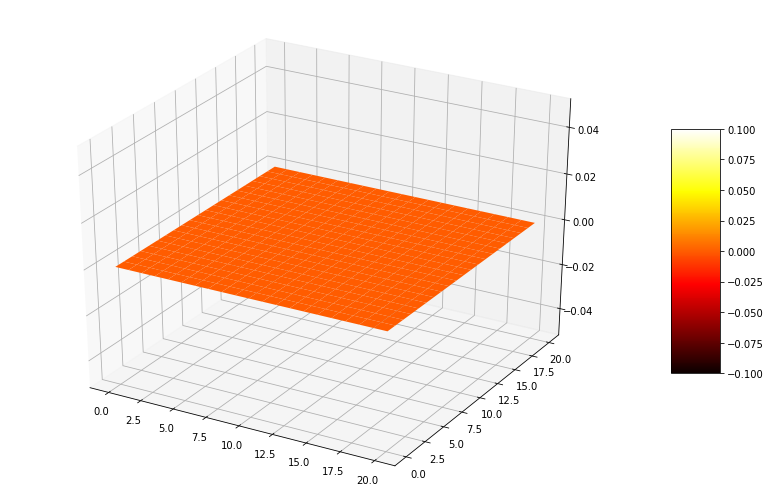

Iteration:  1
Evaluating Policy..
114.9639248625787
94.5326486854627
78.8039507441899
65.61492395376058
54.67159961847807
45.7200113616135
38.20987496016909
31.90536103246643
27.34075340485697
23.76956037565907
Improving Policy..


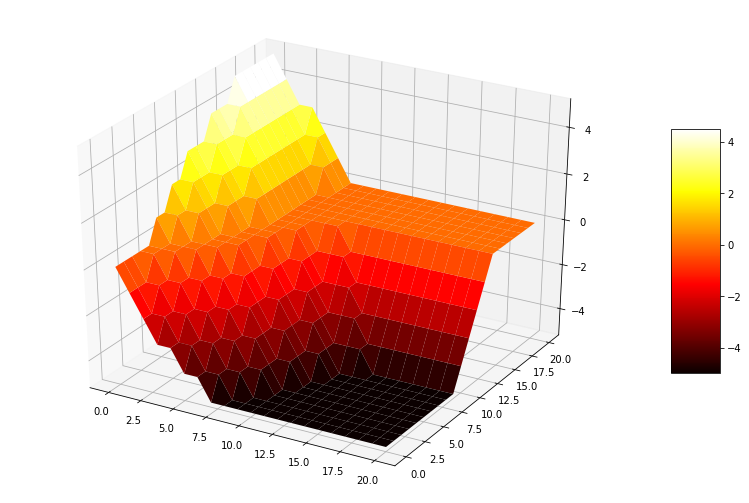

seconds:  114.23500000000058
Iteration:  2
Evaluating Policy..
118.90177497390647
42.75586312414532
21.9662729483245
17.88203343670085
14.409292911393607
11.473123242433985
9.179856143055872
7.469816188881282
6.19077842671237
5.2000169969966805
Improving Policy..


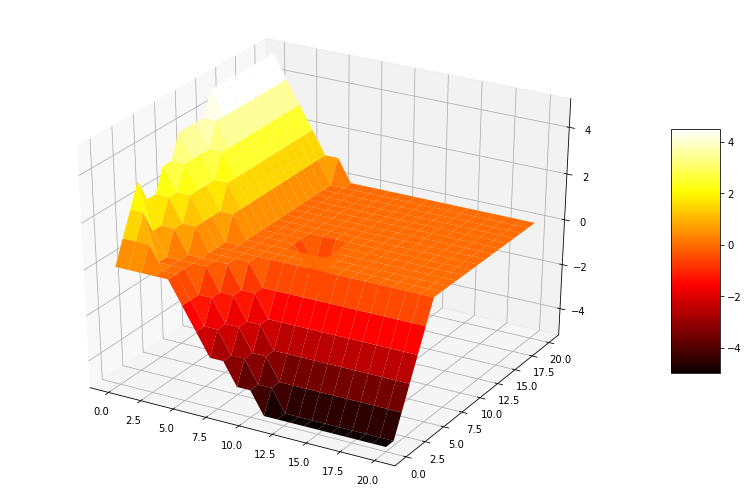

seconds:  124.42199999999866
Iteration:  3
Evaluating Policy..
20.736753713124926
13.541975733272864
10.693589309036156
8.033774208565262
5.83572447799537
4.27849482912535
3.2352587421679004
2.528727857452111
2.0247599806514813
1.64409205698513
Improving Policy..


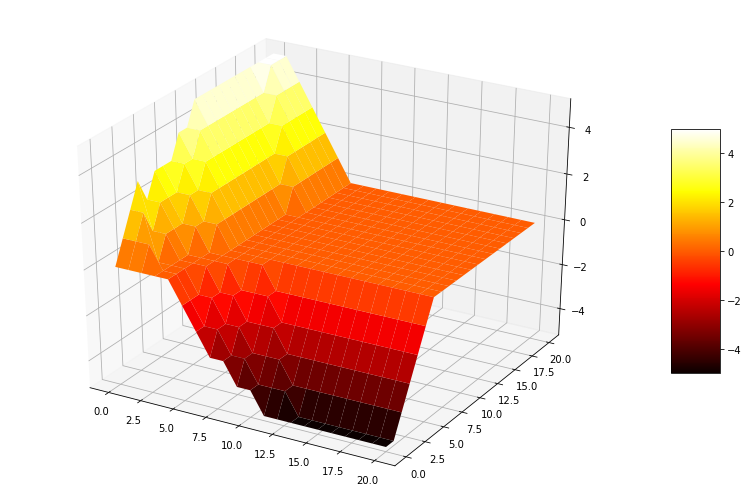

seconds:  119.73400000000038
Iteration:  4
Evaluating Policy..
3.8422682685148857
1.1199139644013485
0.9223429459694898
0.7691841915622035
0.6491428937786168
0.5468685924658985
0.45465059979005673
0.3732792922937733
0.30484747168645754
0.24921455707215046
Improving Policy..


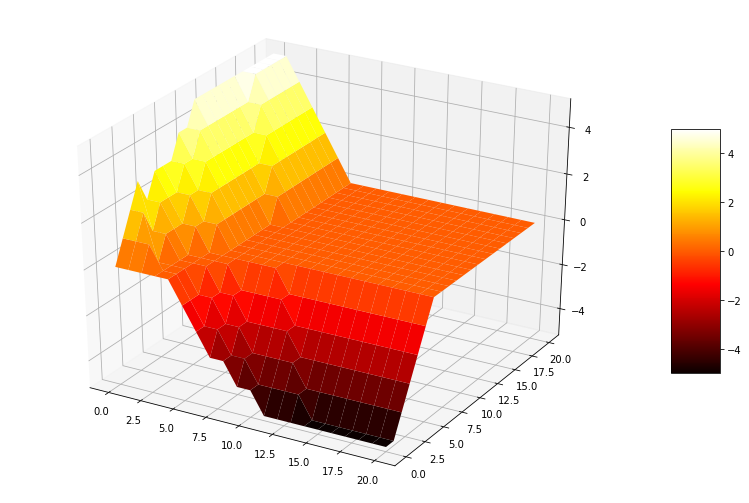

seconds:  120.25
Iteration:  5
Evaluating Policy..
0.2796312483461634
0.16865763919690835
0.13978728593974665
0.11655602714483848
0.09728880562465747
0.08105939908421078
0.06746870212430167
0.056176847157871634
0.04682254521082996
0.039068576950626266
Improving Policy..


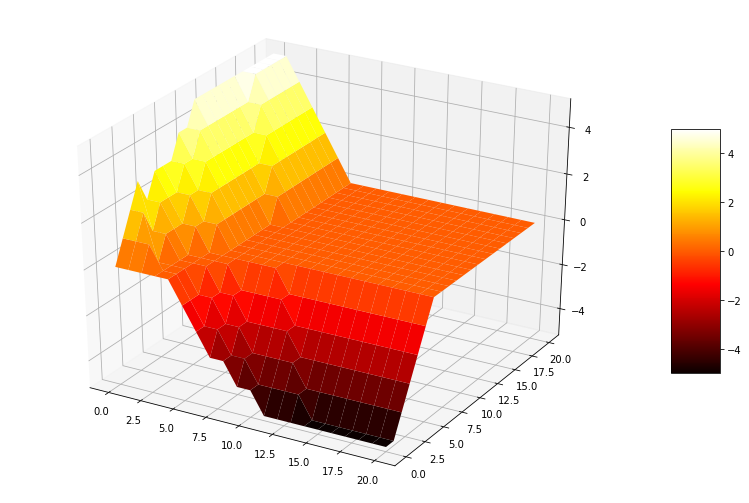

seconds:  120.95299999999952
Iteration:  6
Evaluating Policy..
0.03262900970901228
0.02727067806836203
0.022804993856766487
0.019078819764104082
0.015966953806128004
0.013366399751362223
0.011192032134999863
0.009373262883059397
Improving Policy..


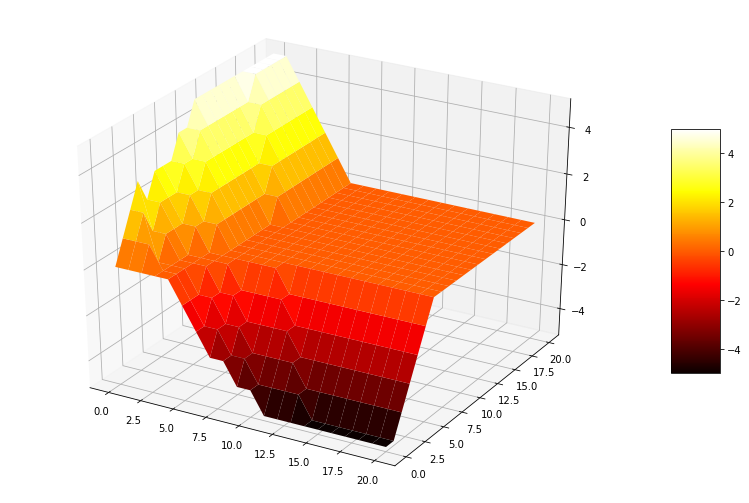

seconds:  109.32800000000134


In [129]:
policy, value = Policy_Iteration(params)

## Visualise Policy

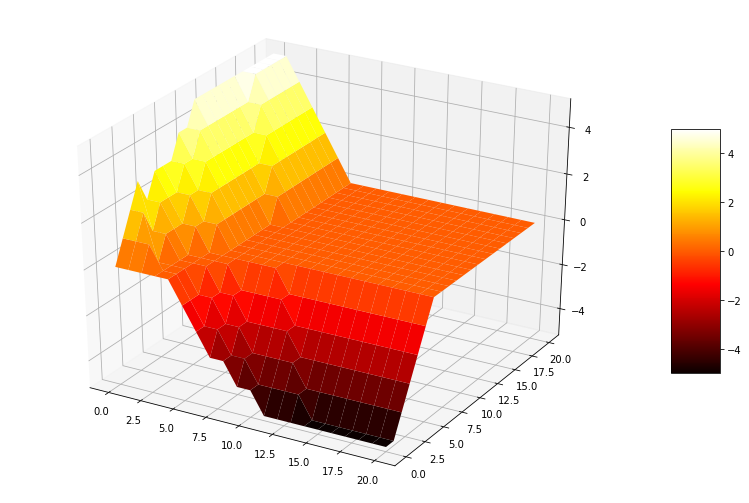

In [117]:
fig = plt.figure(figsize =(14, 9)) 
ax = plt.axes(projection ='3d') 
xx, yy = np.meshgrid(range(21), range(21))
my_cmap = plt.get_cmap('hot')
surf = ax.plot_surface(xx, yy, policy,cmap = my_cmap,edgecolor ='none')
fig.colorbar(surf, ax = ax, shrink = 0.5, aspect = 5)
plt.show() 

In [ ]:
Misc:
    #         axes[itr].imshow(policy, cmap='hot', interpolation='nearest')
#         axes[itr].set(aspect='equal')
#         plt.pause(0.05)
#     fig, axes = plt.subplots(params["num_iters"], 1, figsize=(5,5*params["num_iters"]))
